In [652]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [653]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(2, 2), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1))
  (conv_drop): Dropout2d(p=0.5)
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1), ceil_mode=False)
  (fc1): Linear(in_features=50176, out_features=1000, bias=True)
  (fc2): Linear(in_features=1000, out_features=136, bias=True)
)


In [654]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
#data_transform = None
data_transform = transforms.Compose([
    
        Rescale(250),
        RandomCrop(244), 
        Normalize(),
        ToTensor()
    
 
    ])

 
# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [655]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='data/training_frames_keypoints.csv',
                                             root_dir='data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())
 

Number of images:  3462
0 torch.Size([1, 244, 244]) torch.Size([68, 2])
1 torch.Size([1, 244, 244]) torch.Size([68, 2])
2 torch.Size([1, 244, 244]) torch.Size([68, 2])
3 torch.Size([1, 244, 244]) torch.Size([68, 2])


In [656]:
# load training data in batches
batch_size = 10

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=0)


In [657]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='data/test_frames_keypoints.csv',
                                             root_dir='data/test/',
                                             transform=data_transform)




# load test data in batches
batch_size = 10

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

In [658]:
from torch.autograd import Variable
def net_sample_output():
    
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']
        
        # wrap images in a torch Variable
        # key_pts do not need to be wrapped until they are used for training
        images = Variable(images)
        a=nn.Sigmoid()
        images =a(images)
        
        
        
        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [659]:


# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())



torch.Size([10, 1, 244, 244])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [660]:
 def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


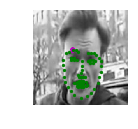

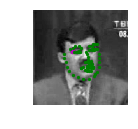

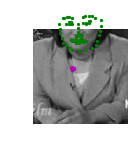

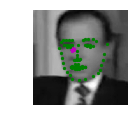

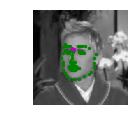

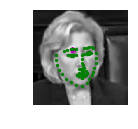

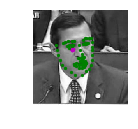

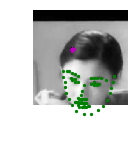

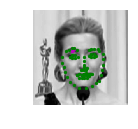

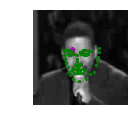

In [661]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

In [663]:
import torch.optim as optim
from torchvision import models
criterion = nn.CrossEntropyLoss() 
criterion = torch.nn.MSELoss(size_average=True)
 
net=Net()
#models.vgg16(pretrained=True)
  
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)



...

Ellipsis

In [625]:
import torch.optim as optim


criterion = nn.MSELoss()  
criterion = torch.nn.MSELoss(size_average=True)
 

model=Net()

optimizer =optim.Adam(model.parameters(), lr=0.001)
 

In [634]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']
            a=nn.Sigmoid()
            
            images =a(images)
            
            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)
            
            # wrap them in a torch Variable
            images, key_pts = Variable(images), Variable(key_pts).float()

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

               # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.data[0]
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/1000))
                running_loss = 0.0

    print('Finished Training')

In [635]:


# train your network
n_epochs = 1 # start small, and increase when you've decided on your model structure and hyperparams

train_net(n_epochs)



Epoch: 1, Batch: 10, Avg. Loss: 0.007792794227600098
Epoch: 1, Batch: 20, Avg. Loss: 0.007654798030853271
Epoch: 1, Batch: 30, Avg. Loss: 0.007399533390998841
Epoch: 1, Batch: 40, Avg. Loss: 0.007077470898628235
Epoch: 1, Batch: 50, Avg. Loss: 0.006625564813613892
Epoch: 1, Batch: 60, Avg. Loss: 0.008112844467163085
Epoch: 1, Batch: 70, Avg. Loss: 0.007192064642906189
Epoch: 1, Batch: 80, Avg. Loss: 0.007629140734672546
Epoch: 1, Batch: 90, Avg. Loss: 0.007850313603878022
Epoch: 1, Batch: 100, Avg. Loss: 0.006933615446090698
Epoch: 1, Batch: 110, Avg. Loss: 0.0073007033467292785
Epoch: 1, Batch: 120, Avg. Loss: 0.007851787567138672
Epoch: 1, Batch: 130, Avg. Loss: 0.007393593311309814
Epoch: 1, Batch: 140, Avg. Loss: 0.007960210561752319
Epoch: 1, Batch: 150, Avg. Loss: 0.006965464890003204
Epoch: 1, Batch: 160, Avg. Loss: 0.0074025639295578005
Epoch: 1, Batch: 170, Avg. Loss: 0.007172668516635895
Epoch: 1, Batch: 180, Avg. Loss: 0.0070105305314064024
Epoch: 1, Batch: 190, Avg. Loss: 0

In [628]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 244, 244])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


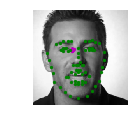

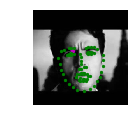

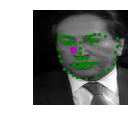

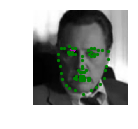

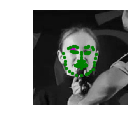

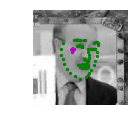

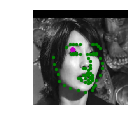

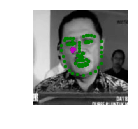

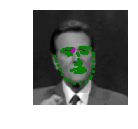

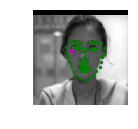

In [629]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)


In [373]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([10, 1, 244, 244])
torch.Size([10, 68, 2])
torch.Size([10, 68, 2])


In [432]:
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 5x5 square convolution kernel
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)

        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))

        # 2 is ame as (2, 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)

        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [433]:
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:       # Get the products
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [434]:
params = list(net.parameters())
print(len(params))       # 10: 10 sets of trainable parameters

print(params[0].size())  

10
torch.Size([6, 1, 5, 5])
